# Evaluación modelos CO y FHMM

En esta etapa se ponen a prueba los modelos de desagregación previamente entrenados. Para ello se deberia utilizar un conjunto de datos distinto al usado en el entrenamiento, con tal de aplicar las métricas provistas por NILMTK.

Librerías y otros ajustes:

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import warnings
warnings. filterwarnings("ignore")
plt.style.use('bmh')

from nilmtk import TimeFrame, MeterGroup, HDFDataStore, DataSet
from nilmtk.metrics import fraction_energy_assigned_correctly, mean_normalized_error_power
from nilmtk.metrics import rms_error_power, f1_score, error_in_assigned_energy

data_dir='./data/'

## Set de Validación

In [2]:
#Set para validación
valid = DataSet('dsual.h5')
valid.set_window(start="2022-02-02 12:00:00", end="2022-02-02 12:58:00")
valid_elec = valid.buildings[1].elec

print('Medidor de cabecera para desagregación:')
valid_Main = valid_elec.mains()
print(valid_Main)

print('\nDispositivos para validación de entrenamiento:')
valid_Devices = valid_elec.select(instance=[2,3,4,5,6])
print(valid_Devices)

Medidor de cabecera para desagregación:
ElecMeter(instance=1, building=1, dataset='DSUAL', site_meter, appliances=[])

Dispositivos para validación de entrenamiento:
MeterGroup(meters=
  ElecMeter(instance=2, building=1, dataset='DSUAL', appliances=[Appliance(type='fan', instance=1)])
  ElecMeter(instance=3, building=1, dataset='DSUAL', appliances=[Appliance(type='freezer', instance=1)])
  ElecMeter(instance=4, building=1, dataset='DSUAL', appliances=[Appliance(type='television', instance=1)])
  ElecMeter(instance=5, building=1, dataset='DSUAL', appliances=[Appliance(type='vacuum cleaner', instance=1)])
  ElecMeter(instance=6, building=1, dataset='DSUAL', appliances=[Appliance(type='boiler', instance=1)])
)


### Etiquetas

In [4]:
labels = pd.DataFrame({'Instances': list(range(1,7)),
                       'Meters': ['main',  'fan', 'freezer', 'television','vacuum Cleaner', 'boiler']})
Meters={}
for x in range(len(labels)): Meters[valid_elec[x+1]]=labels['Meters'][x]

### Gráficos

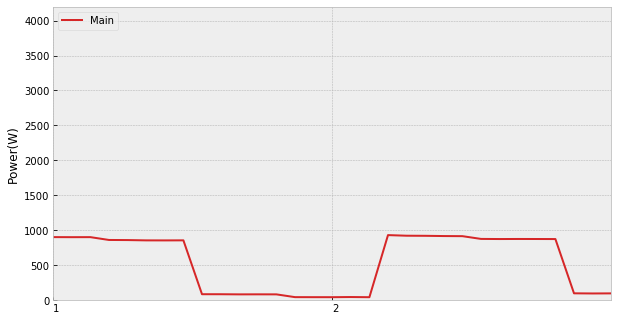

In [5]:
rcParams['figure.figsize'] = (10, 6)

t0='2022-02-02 12:00:00+01:00'
t1='2022-02-02 12:15:00+01:00'
t2='2022-02-02 12:30:00+01:00'

ax1 = next(valid_Main.load(ac_type='active', sample_period=60, resample_kwargs={'how':'first'}))[t0:t2].plot(c='tab:red') 
ax1.legend(['Main'], loc='upper left') #etiquetas
ax1.minorticks_off()
ax1.set(xticks=(t0, t1))
ax1.set_xticklabels(labels=['1','2'], ha='left', rotation=0)    
ax1.set_ylabel('Power(W)')
ax1.set_ylim(0,4200)
plt.savefig('./data/images/5.1_Plot_valid_main.svg', bbox_inches='tight', transparent=True)
pass

IndexError: list index out of range

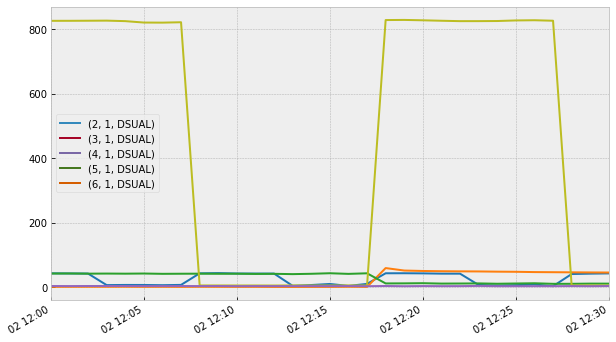

In [7]:
rcParams['figure.figsize'] = (10, 6)

t0='2022-02-02 12:00:00+01:00'
t1='2022-02-02 12:15:00+01:00'
t2='2022-02-02 12:30:00+01:00'

ax2 = valid_Devices.dataframe_of_meters(ac_type='active', sample_period=60, resample_kwargs={'how':'first'})[t0:t2].plot()  
#colores
colors=['tab:blue','tab:orange','tab:green','tab:olive','tab:purple','tab:cyan']
c=0
for col in colors:    
    ax2.get_lines()[c].set_color(col)
    c=c+1   
ax2.legend(list(Meters.values())[4:10])
ax2.minorticks_off()
ax2.set(xticks=(t1, t2))
ax2.set_xticklabels(labels=['10-11','11-11'], ha='left', rotation=0)    
ax2.set_ylabel('Power(W)')
plt.savefig('./data/images/5.2_Plot_valid_devices.svg', bbox_inches='tight', transparent=True)
pass

### Desagregación para validación

La desagregación de los datos de validación se realiza utilizando los datos del MeterGroup valid_Main, el cual contiene el ElecMeter de los datos agregados del sistema eléctrico. Así, el medidor principal  será el dato de entrada para cada uno de los modelos de desagregación entrenados.

In [8]:

train = DataSet('dsual.h5')

train.set_window(start="2022-02-02 12:00:00", end="2022-02-02 12:58:00")
train_elec = train.buildings[1].elec

#Dispositivos para entrenamiento
train_Devices = train_elec.select(instance=[2,3,4,5,6])
train_Devices


#solo entrenamiento paso 4
from nilmtk.legacy.disaggregate import CombinatorialOptimisation, FHMM
periods = {'10s':10 , '30s':30, '60s':60, '5min':60*5, '10min':60*10, '15min':60*15, '30min':60*30}
methods = ['mean', 'median', 'first']
times = {}

data_dir = './data/'
times = {} #almacena tiempos de ejecución
null={} #diccionario nulo


for sp_name, sp in periods.items():
    t = []
    for method in methods:
        models={'FHMM':FHMM()}
        for model_name, model in models.items():
            model.MIN_CHUNK_LENGTH = 1   
            print("*"*20 + ' ' + model_name + ' ' + sp_name+ ' ' + method + "*"*20)   
            import time
            start = time.time()
            model.train(train_Devices,
                num_states_dict={}, #diccionario de estados nulo, por defecto
                ac_type='active', #potencia activa, por defecto
                sample_period=1, #cambio de muestreo
                resample_kwargs={'how':'first'})#método 

            t.append(round(time.time()-start,2)) #tiempo de simulación

            #Guarda modelo
            #model_dir = dir_models + model_name + '_1s_first_model.pickle'
            #print(model_dir)
            #model.export_model(model_dir) 
            output=HDFDataStore(data_dir+'NILM/Results/'+model_name+'_'+sp_name+'_'+method+'_pred.h5', 'w')
            
            model.disaggregate(valid_Main, output, sample_period=sp, resample_kwargs={'how':method}, ac_type='active')
            output.close()
            end = time.time()-start
            t.append(round(end,2))  

    times[sp_name] = t


times_v = pd.DataFrame(times,index=['CO_mean', 'FHMM_mean', 'CO_median', 'FHMM_median','CO_first', 'FHMM_first'])          
            
    
print('\n\nDone!')

******************** FHMM 10s mean********************
Training model for submeter 'ElecMeter(instance=2, building=1, dataset='DSUAL', appliances=[Appliance(type='fan', instance=1)])' with 3 states
Training model for submeter 'ElecMeter(instance=3, building=1, dataset='DSUAL', appliances=[Appliance(type='freezer', instance=1)])' with 3 states
Training model for submeter 'ElecMeter(instance=4, building=1, dataset='DSUAL', appliances=[Appliance(type='television', instance=1)])' with 3 states
Training model for submeter 'ElecMeter(instance=5, building=1, dataset='DSUAL', appliances=[Appliance(type='vacuum cleaner', instance=1)])' with 3 states
Training model for submeter 'ElecMeter(instance=6, building=1, dataset='DSUAL', appliances=[Appliance(type='boiler', instance=1)])' with 1 states
******************** FHMM 10s median********************
Training model for submeter 'ElecMeter(instance=2, building=1, dataset='DSUAL', appliances=[Appliance(type='fan', instance=1)])' with 3 states
Train

Training model for submeter 'ElecMeter(instance=4, building=1, dataset='DSUAL', appliances=[Appliance(type='television', instance=1)])' with 3 states
Training model for submeter 'ElecMeter(instance=5, building=1, dataset='DSUAL', appliances=[Appliance(type='vacuum cleaner', instance=1)])' with 3 states
Training model for submeter 'ElecMeter(instance=6, building=1, dataset='DSUAL', appliances=[Appliance(type='boiler', instance=1)])' with 1 states
******************** FHMM 5min first********************
Training model for submeter 'ElecMeter(instance=2, building=1, dataset='DSUAL', appliances=[Appliance(type='fan', instance=1)])' with 3 states
Training model for submeter 'ElecMeter(instance=3, building=1, dataset='DSUAL', appliances=[Appliance(type='freezer', instance=1)])' with 3 states
Training model for submeter 'ElecMeter(instance=4, building=1, dataset='DSUAL', appliances=[Appliance(type='television', instance=1)])' with 3 states
Training model for submeter 'ElecMeter(instance=5, bu

Training model for submeter 'ElecMeter(instance=6, building=1, dataset='DSUAL', appliances=[Appliance(type='boiler', instance=1)])' with 1 states


Done!


In [9]:
times_v.transpose()

,CO_mean,FHMM_mean,CO_median,FHMM_median,CO_first,FHMM_first
10s,7.19,7.73,7.26,7.51,8.03,8.38
30s,8.08,8.37,8.07,8.33,8.08,8.34
60s,7.91,8.16,7.90,8.14,7.97,8.20
5min,7.97,8.21,8.58,8.81,8.31,8.60
10min,8.84,9.08,7.97,8.22,7.97,8.22
15min,7.98,8.22,7.94,8.17,7.97,8.22
30min,7.85,8.12,7.98,8.20,8.00,8.24


In [10]:
 
for sp_name, sp in periods.items():
    t = []
    for method in methods:
        models={'CO':CombinatorialOptimisation()}
        for model_name, model in models.items():
            model.MIN_CHUNK_LENGTH = 1   
            print("*"*20 + ' ' + model_name + ' ' + sp_name+ ' ' + method + "*"*20)   
            import time
            start = time.time()
            model.train(train_Devices,
                num_states_dict={}, #diccionario de estados nulo, por defecto
                ac_type='active', #potencia activa, por defecto
                sample_period=1, #cambio de muestreo
                resample_kwargs={'how':'first'})#método 

            t.append(round(time.time()-start,2)) #tiempo de simulación

            #Guarda modelo
            #model_dir = dir_models + model_name + '_1s_first_model.pickle'
            #print(model_dir)
            #model.export_model(model_dir) 
            output=HDFDataStore(data_dir+'NILM/Results/'+model_name+'_'+sp_name+'_'+method+'_pred.h5', 'w')
            
            model.disaggregate(valid_Main, output, sample_period=sp, resample_kwargs={'how':method}, ac_type='active')
            output.close()
            end = time.time()-start
            t.append(round(end,2))  

    times[sp_name] = t


times_v = pd.DataFrame(times,index=['CO_mean', 'FHMM_mean', 'CO_median', 'FHMM_median','CO_first', 'FHMM_first'])    
#times_v = pd.DataFrame(times,index=['CO_mean',  'CO_median', 'CO_first'])            
            
    
print('\n\nDone!')

******************** CO 10s mean********************
Training model for submeter 'ElecMeter(instance=2, building=1, dataset='DSUAL', appliances=[Appliance(type='fan', instance=1)])'
Training model for submeter 'ElecMeter(instance=3, building=1, dataset='DSUAL', appliances=[Appliance(type='freezer', instance=1)])'
Training model for submeter 'ElecMeter(instance=4, building=1, dataset='DSUAL', appliances=[Appliance(type='television', instance=1)])'
Training model for submeter 'ElecMeter(instance=5, building=1, dataset='DSUAL', appliances=[Appliance(type='vacuum cleaner', instance=1)])'
Training model for submeter 'ElecMeter(instance=6, building=1, dataset='DSUAL', appliances=[Appliance(type='boiler', instance=1)])'
Done training!
Estimating power demand for 'ElecMeter(instance=2, building=1, dataset='DSUAL', appliances=[Appliance(type='fan', instance=1)])'
Estimating power demand for 'ElecMeter(instance=3, building=1, dataset='DSUAL', appliances=[Appliance(type='freezer', instance=1)])'


******************** CO 60s mean********************
Training model for submeter 'ElecMeter(instance=2, building=1, dataset='DSUAL', appliances=[Appliance(type='fan', instance=1)])'
Training model for submeter 'ElecMeter(instance=3, building=1, dataset='DSUAL', appliances=[Appliance(type='freezer', instance=1)])'
Training model for submeter 'ElecMeter(instance=4, building=1, dataset='DSUAL', appliances=[Appliance(type='television', instance=1)])'
Training model for submeter 'ElecMeter(instance=5, building=1, dataset='DSUAL', appliances=[Appliance(type='vacuum cleaner', instance=1)])'
Training model for submeter 'ElecMeter(instance=6, building=1, dataset='DSUAL', appliances=[Appliance(type='boiler', instance=1)])'
Done training!
Estimating power demand for 'ElecMeter(instance=2, building=1, dataset='DSUAL', appliances=[Appliance(type='fan', instance=1)])'
Estimating power demand for 'ElecMeter(instance=3, building=1, dataset='DSUAL', appliances=[Appliance(type='freezer', instance=1)])'


******************** CO 10min mean********************
Training model for submeter 'ElecMeter(instance=2, building=1, dataset='DSUAL', appliances=[Appliance(type='fan', instance=1)])'
Training model for submeter 'ElecMeter(instance=3, building=1, dataset='DSUAL', appliances=[Appliance(type='freezer', instance=1)])'
Training model for submeter 'ElecMeter(instance=4, building=1, dataset='DSUAL', appliances=[Appliance(type='television', instance=1)])'
Training model for submeter 'ElecMeter(instance=5, building=1, dataset='DSUAL', appliances=[Appliance(type='vacuum cleaner', instance=1)])'
Training model for submeter 'ElecMeter(instance=6, building=1, dataset='DSUAL', appliances=[Appliance(type='boiler', instance=1)])'
Done training!
Estimating power demand for 'ElecMeter(instance=2, building=1, dataset='DSUAL', appliances=[Appliance(type='fan', instance=1)])'
Estimating power demand for 'ElecMeter(instance=3, building=1, dataset='DSUAL', appliances=[Appliance(type='freezer', instance=1)])

******************** CO 30min mean********************
Training model for submeter 'ElecMeter(instance=2, building=1, dataset='DSUAL', appliances=[Appliance(type='fan', instance=1)])'
Training model for submeter 'ElecMeter(instance=3, building=1, dataset='DSUAL', appliances=[Appliance(type='freezer', instance=1)])'
Training model for submeter 'ElecMeter(instance=4, building=1, dataset='DSUAL', appliances=[Appliance(type='television', instance=1)])'
Training model for submeter 'ElecMeter(instance=5, building=1, dataset='DSUAL', appliances=[Appliance(type='vacuum cleaner', instance=1)])'
Training model for submeter 'ElecMeter(instance=6, building=1, dataset='DSUAL', appliances=[Appliance(type='boiler', instance=1)])'
Done training!
Estimating power demand for 'ElecMeter(instance=2, building=1, dataset='DSUAL', appliances=[Appliance(type='fan', instance=1)])'
Estimating power demand for 'ElecMeter(instance=3, building=1, dataset='DSUAL', appliances=[Appliance(type='freezer', instance=1)])

In [11]:
times_v.transpose()

,CO_mean,FHMM_mean,CO_median,FHMM_median,CO_first,FHMM_first
10s,6.06,6.31,6.04,6.28,6.06,6.29
30s,6.07,6.28,6.05,6.28,6.05,6.29
60s,6.06,6.29,6.06,6.30,6.04,6.28
5min,6.03,6.25,6.08,6.29,6.05,6.27
10min,6.10,6.32,6.08,6.30,6.06,6.29
15min,6.06,6.29,6.06,6.30,6.03,6.26
30min,6.11,6.35,5.83,6.04,5.94,6.16
